# Constrained Optimization

This section covers local *constrained* optimization. We will be using `scipy.optimize` module for minimizing an analytical function with constraints. Going through the following documentation will help in understanding the code:

1. [Scipy minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)
2. [Matplotlib contour plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html)
3. [Scipy nonlinear constraint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.NonlinearConstraint.html#scipy.optimize.NonlinearConstraint)

Below block of code imports all the required packages:

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

Consider the optimization problem described below:

$$
    \begin{aligned}
        \min_{x_1,x_2} \quad & x_1^2 - \frac{x_1}{2} - x_2 - 2 \\
        \textrm{subject to} \quad & x_1^2 -4x_1 + x_2 + 1  \leq 0 \\
        \quad & \frac{x_1^2}{2} + x_2^2 - x_1 - 4 \leq 0 \\
    \end{aligned}
$$

**Question**: Plot the objective function contour and $g_i=0$ curves.

**Answer**: Below block of code defines various functions. Read the comments to understand the code.

In [64]:
def f(x):
    """
        Function which calculates the function value at given x.
        
        Input:
        x - 1D/2D numpy array
    """

    # Number of dimensions of input
    dim = x.ndim

    # To ensure n x 2
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = x[:,0]
    x2 = x[:,1]
    
    y = x1**2 - x1/2 - x2 - 2

    y = y.reshape(-1,1)
    
    if dim == 1:
        y = y.reshape(-1,)
    
    return y

def g1(x):
    """
        Function which calculates the g1 value at given x.
        
        Input:
        x - 1D/2D numpy array
    """

    # Number of dimensions of input
    dim = x.ndim

    # To ensure n x 2
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = x[:,0]
    x2 = x[:,1]
    
    g1 = x1**2 - 4*x1 + x2 + 1

    g1 = g1.reshape(-1,1)
    
    if dim == 1:
        g1 = g1.reshape(-1,)
    
    return g1

def g2(x):
    """
        Function which calculates the g2 value at given x.
        
        Input:
        x - 1D/2D numpy array
    """

    # Number of dimensions of input
    dim = x.ndim

    # To ensure n x 2
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = x[:,0]
    x2 = x[:,1]
    
    g2 = x1**2 / 2 + x2**2 - x1 - 4

    g2 = g2.reshape(-1,1)
    
    if dim == 1:
        g2 = g2.reshape(-1,)
    
    return g2

def plot_prob():
    """
        Function which plots the function contour and constraints
    """

    num_points = 100

    # Defining x and y values
    x = np.linspace(-3,5,num_points)
    y = np.linspace(-3,4,num_points)

    # Creating a mesh at which values and 
    # gradient will be evaluated and plotted
    X, Y = np.meshgrid(x, y)

    # Evaluating the function values at meshpoints
    obj = f(np.hstack((X.reshape(-1,1),Y.reshape(-1,1)))).reshape(num_points,num_points)
    const1 = g1(np.hstack((X.reshape(-1,1),Y.reshape(-1,1)))).reshape(num_points,num_points)
    const2 = g2(np.hstack((X.reshape(-1,1),Y.reshape(-1,1)))).reshape(num_points,num_points)

    # Plotting the filled contours
    fig, ax = plt.subplots(figsize=(7,5))
    CS = ax.contourf(X, Y, obj, levels=30)
    fig.colorbar(CS, orientation='vertical')

    # Plotting g1
    ax.contour(X, Y, const1, levels=[0], colors="k")
    ax.contourf(X, Y, const1, levels=np.linspace(0,const1.max()), colors="white", alpha=0.2, antialiased = True)
    ax.annotate('g1', xy =(3.1, 2.0))
 
    # Plotting g2
    ax.contour(X, Y, const2, levels=[0], colors="k")
    ax.contourf(X, Y, const2, levels=np.linspace(0,const2.max()), colors="white", alpha=0.2, antialiased = True)
    ax.annotate('g2', xy =(0.0, 2.2))

    ax.set_xlabel("$x_1$", fontsize=14)
    ax.set_ylabel("$x_2$", fontsize=14)

    # Few annotations
    ax.annotate('A', xy =(-0.1, -1.8), c='r', fontweight='bold')
    ax.annotate('B', xy =(1.0, 1.8), c='r', fontweight='bold')
    ax.annotate('C', xy =(3.0, 1.2), c='r', fontweight='bold')
    ax.annotate('D', xy =(3.5, -0.6), c='r', fontweight='bold')

    return ax

Below block of code makes a contour plot of the objective with constraints using the functions defined in previous block:

<Axes: xlabel='$x_1$', ylabel='$x_2$'>

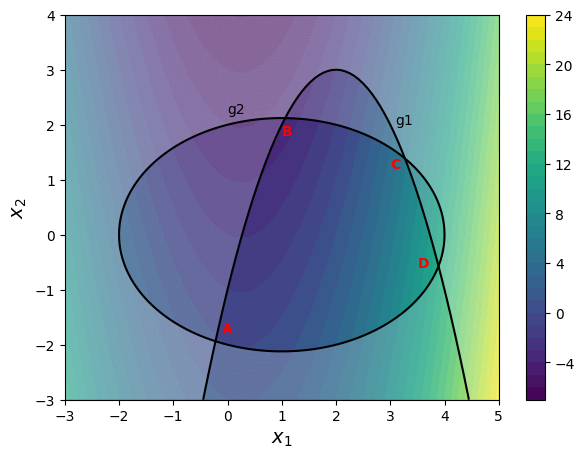

In [65]:
plot_prob()

The black curves denote $g_i=0$ and only the unmasked region ABCDA is **feasible**.

**Question**: Use SLSQP method for solving the optimization problem.

**Answer**: Below block of code defines various functions which are used during the optimization. Read comments in the function for more details.

In [72]:
def callback(x):
    """
        Function which is called after every iteration of optimization.
        It stores the value of x1, x2, and function value.
        
        Input: Current x value
        Output: None
    """
    
    history["x1"].append(x[0])
    history["x2"].append(x[1])
    history["f"].append(f(x))
    history["g1"].append(g1(x))
    history["g2"].append(g2(x))
    
def opt_plots(history, method):
    """
        Function used for plotting the results of the optimization.
        
        Input: 
        history - A dict which contains three key-value pairs - x1, x2, and f.
        Each of this pair should be a list which contains values of 
        the respective quantity at each iteration. Look at the usage of this
        function in following blocks for better understanding.
        
        method - A str which denotes the method used for optimization.
        It is only used in the title of the plots.
    """
    
    # Number of iterations.
    # Subtracting 1, since it also contains starting point
    num_itr = len(history["x1"]) - 1

    # Plotting the convergence history
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(np.arange(num_itr+1), history["x1"], "k", marker=".", label="$x_1$")
    ax.plot(np.arange(num_itr+1), history["x2"], "b", marker=".", label="$x_2$")
    ax.plot(np.arange(num_itr+1), history["f"], "g", marker=".", label="$f$")
    ax.plot(np.arange(num_itr+1), history["g1"], "k--", marker=".", label="$g_1$")
    ax.plot(np.arange(num_itr+1), history["g2"], "g--", marker=".", label="$g_2$")
    ax.set_xlabel("Iterations", fontsize=14)
    ax.set_xlim(left=0, right=num_itr)
    ax.set_ylabel("Quantities", fontsize=14)
    ax.grid()
    ax.legend(fontsize=12)
    ax.set_title("Convergence history - " + method, fontsize=14)

    # Plotting function contours
    ax = plot_prob()

    # PLotting other things
    ax.plot(history["x1"], history["x2"], "k", marker=".", label="Path")
    ax.scatter(history["x1"][0], history["x2"][0], label="Starting point", c="red")
    ax.scatter(history["x1"][-1], history["x2"][-1], label="Final point", c="orange")
    ax.legend(loc='upper left')

Below block of code defines various parameters for optimization using **SLSQP** method:

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.523406546437449
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
Value of x1 at optimum: 1.0623763071639867
Value of x2 at optimum: 2.120861810878845
Value of g1 at optimum: [2.46287879e-10]
Value of g2 at optimum: [2.22692002e-07]


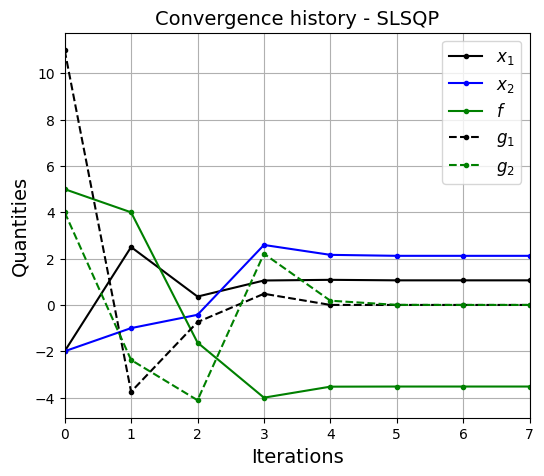

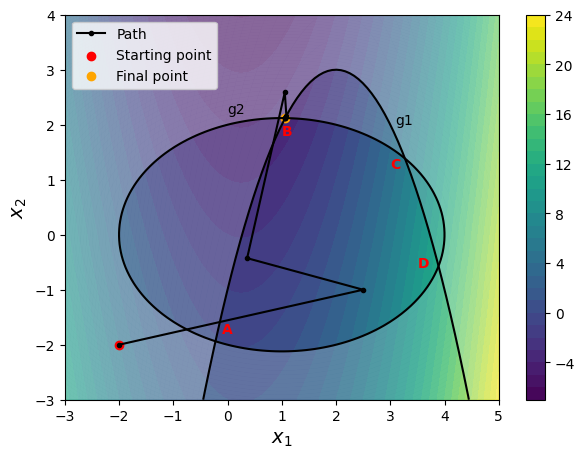

In [73]:
# Starting point
x0 = np.array([-2.0, -2.0])

# Solver
method = "SLSQP"

# Defines which finite difference scheme to use. Possible values are:
# "2-point" - forward/backward difference
# "3-point" - central difference
# "cs" - complex step
jac = "3-point"

# Defining dict for storing history of optimization
history = {}
history["x1"] = [x0[0]]
history["x2"] = [x0[1]]
history["f"] = [f(x0)]
history["g1"] = [g1(x0)]
history["g2"] = [g2(x0)]

# Solver options
options ={
    "disp": True
}

# Setting constraints - optimizer needs a list of Nonlinear constraints objects
# Read the documentation for more details.
constraints = [NonlinearConstraint(g1, -np.inf, 0),
               NonlinearConstraint(g2, -np.inf, 0)]

# Minimize the function
result = minimize(fun=f, x0=x0, method=method, jac=jac, 
                  constraints=constraints, callback=callback, 
                  options=options)

# Print value of x
print("Value of x1 at optimum: {}".format(result.x[0]))
print("Value of x2 at optimum: {}".format(result.x[1]))
print("Value of g1 at optimum: {}".format(g1(result.x)))
print("Value of g2 at optimum: {}".format(g2(result.x)))

# Convergence plots
opt_plots(history, method=method)

> **_NOTE:_** The optimization problem doesn't have bounds but `SLSQP` can handle bounds unlike `BFGS` or `Conjugate Gradient` methods.
You can use `bounds` argument in minimize function to define bounds.